# Import

In [1]:
import pandas
import sklearn
import evaluation
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
GPU_fix = "MemoryFix" # Choose "Disable", "MemoryFix" or "None"

if GPU_fix == "Disable":
    try:
        # Disable all GPUS
        tf.config.set_visible_devices([], 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
elif GPU_fix == "MemoryFix":
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

1 Physical GPUs, 1 Logical GPUs


# Read training data

In [147]:
# https://www.kaggle.com/sionek/ugbc-gs
folder = 'tau_data/'
data = pandas.read_csv(folder + 'training.csv.zip', index_col='id')
#--------------- feature engineering -------------- #
def add_features(df):
    # features used by the others on Kaggle
    df['NEW_FD_SUMP']=df['FlightDistance']/(df['p0_p']+df['p1_p']+df['p2_p'])
    df['NEW5_lt']=df['LifeTime']*(df['p0_IP']+df['p1_IP']+df['p2_IP'])/3
    df['p_track_Chi2Dof_MAX'] = df.loc[:, ['p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof']].max(axis=1)
    #df['flight_dist_sig'] = df['FlightDistance']/df['FlightDistanceError'] # modified to:
    df['flight_dist_sig2'] = (df['FlightDistance']/df['FlightDistanceError'])**2
    # features from phunter
    df['flight_dist_sig'] = df['FlightDistance']/df['FlightDistanceError']
    df['NEW_IP_dira'] = df['IP']*df['dira']
    df['p0p2_ip_ratio']=df['IP']/df['IP_p0p2']
    df['p1p2_ip_ratio']=df['IP']/df['IP_p1p2']
    df['DCA_MAX'] = df.loc[:, ['DOCAone', 'DOCAtwo', 'DOCAthree']].max(axis=1)
    df['iso_bdt_min'] = df.loc[:, ['p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT']].min(axis=1)
    df['iso_min'] = df.loc[:, ['isolationa', 'isolationb', 'isolationc','isolationd', 'isolatione', 'isolationf']].min(axis=1)
    # My:
    # new combined features just to minimize their number;
    # their physical sense doesn't matter
    df['NEW_iso_abc'] = df['isolationa']*df['isolationb']*df['isolationc']
    df['NEW_iso_def'] = df['isolationd']*df['isolatione']*df['isolationf']
    df['NEW_pN_IP'] = df['p0_IP']+df['p1_IP']+df['p2_IP']
    df['NEW_pN_p']  = df['p0_p']+df['p1_p']+df['p2_p']
    df['NEW_IP_pNpN'] = df['IP_p0p2']*df['IP_p1p2']
    df['NEW_pN_IPSig'] = df['p0_IPSig']+df['p1_IPSig']+df['p2_IPSig']
    #My:
    # "super" feature changing the result from 0.988641 to 0.991099
    df['NEW_FD_LT']=df['FlightDistance']/df['LifeTime']
    return df

print("Add features")
train_df = add_features(data)

print("Eliminate features")
filter_out = ['id', 'min_ANNmuon', 'production', 'mass', 'signal',
              'p0_pt', 'p1_pt', 'p2_pt',
              'p0_p', 'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta',
              'isolationa', 'isolationb', 'isolationc', 'isolationd', 'isolatione', 'isolationf',
              'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT',
              'p0_IP', 'p1_IP', 'p2_IP',
              'IP_p0p2', 'IP_p1p2',
              'p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof',
              'p0_IPSig', 'p1_IPSig', 'p2_IPSig',
              'DOCAone', 'DOCAtwo', 'DOCAthree']
filter_out1 = ['id', 'min_ANNmuon', 'production', 'mass', 'signal',
              'SPDhits','CDF1', 'CDF2', 'CDF3',
              'p0_pt', 'p1_pt', 'p2_pt',
              'p0_p', 'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta',
              'isolationa', 'isolationb', 'isolationc', 'isolationd', 'isolatione', 'isolationf',
              'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT',
              'p0_IP', 'p1_IP', 'p2_IP',
              'IP_p0p2', 'IP_p1p2',
              'p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof',
              'p0_IPSig', 'p1_IPSig', 'p2_IPSig',
              'DOCAone', 'DOCAtwo', 'DOCAthree']

Add features
Eliminate features


In [119]:
def preprocess_data(X, scaler=None):
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X

In [144]:
#modified
variables_mod = list(f for f in data.columns if f not in filter_out1)
print(len(variables_mod))

28


In [148]:
print(len([i for i in train_df['signal'].to_numpy() if i == 0]))
train_df = data[variables_mod]
train_df = preprocess_data(train_df)

25879


In [149]:
msk = np.random.rand(len(train_df)) < 0.8
train = train_df[msk]
val = train_df[~msk]

In [150]:
print('validation samples:',len(val))
print('train samples:',len(train))

validation samples: 13688
train samples: 53865


# Baseline training

In [151]:
#Create training arrays
x_train = train
y_train = data['signal'][msk].to_numpy()
y_train = np.expand_dims(y_train,1)
x_val = val
y_val = data['signal'][~msk].to_numpy()
y_val = np.expand_dims(y_val,1)

In [152]:
model1 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(len(variables_mod)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.05)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.05)), 
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.05)), 
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.05)),  
  tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
])
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
from tensorflow.keras.layers import PReLU
model = Sequential()
model.add(Input(shape=len(variables_mod)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(75))
model.add(PReLU())

model.add(Dropout(0.13))
model.add(Dense(60))
model.add(PReLU())

model.add(Dropout(0.11))
model.add(Dense(45))
model.add(PReLU())

model.add(Dropout(0.09))
model.add(Dense(30))
model.add(PReLU())

model.add(Dropout(0.07))
model.add(Dense(15))
model.add(PReLU())

model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='BinaryCrossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [154]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_45 (Dropout)         (None, 28)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 75)                2175      
_________________________________________________________________
p_re_lu_25 (PReLU)           (None, 75)                75        
_________________________________________________________________
dropout_46 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 60)                4560      
_________________________________________________________________
p_re_lu_26 (PReLU)           (None, 60)                60        
_________________________________________________________________
dropout_47 (Dropout)         (None, 60)              

In [155]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=0)

In [156]:

history_1 = model1.fit(x_train, y_train, epochs = 300, batch_size = 128, validation_data = (x_val,y_val))
history = model.fit(x_train, y_train, epochs = 300, batch_size = 128, validation_data = (x_val,y_val))

Epoch 1/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3823 - accuracy: 0.8351 - val_loss: 0.3606 - val_accuracy: 0.8491
Epoch 2/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3671 - accuracy: 0.8423 - val_loss: 0.3347 - val_accuracy: 0.8570
Epoch 3/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3646 - accuracy: 0.8440 - val_loss: 0.3355 - val_accuracy: 0.8595
Epoch 4/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3608 - accuracy: 0.8458 - val_loss: 0.3327 - val_accuracy: 0.8583
Epoch 5/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3604 - accuracy: 0.8451 - val_loss: 0.3339 - val_accuracy: 0.8528
Epoch 6/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3595 - accuracy: 0.8463 - val_loss: 0.3284 - val_accuracy: 0.8562
Epoch 7/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3574 - accuracy: 0.8457 - val_loss: 0.3264 - val_accuracy: 0.8610

Epoch 58/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3491 - accuracy: 0.8520 - val_loss: 0.3268 - val_accuracy: 0.8617
Epoch 59/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3480 - accuracy: 0.8517 - val_loss: 0.3264 - val_accuracy: 0.8621
Epoch 60/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3452 - accuracy: 0.8516 - val_loss: 0.3246 - val_accuracy: 0.8609
Epoch 61/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3472 - accuracy: 0.8513 - val_loss: 0.3233 - val_accuracy: 0.8613
Epoch 62/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3473 - accuracy: 0.8508 - val_loss: 0.3289 - val_accuracy: 0.8589
Epoch 63/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3471 - accuracy: 0.8515 - val_loss: 0.3273 - val_accuracy: 0.8637
Epoch 64/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3481 - accuracy: 0.8513 - val_loss: 0.3330 - val_accuracy:

Epoch 115/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3387 - accuracy: 0.8556 - val_loss: 0.3143 - val_accuracy: 0.8684
Epoch 116/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3407 - accuracy: 0.8566 - val_loss: 0.3160 - val_accuracy: 0.8688
Epoch 117/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3364 - accuracy: 0.8574 - val_loss: 0.3079 - val_accuracy: 0.8711
Epoch 118/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3400 - accuracy: 0.8551 - val_loss: 0.3121 - val_accuracy: 0.8722
Epoch 119/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3419 - accuracy: 0.8561 - val_loss: 0.3044 - val_accuracy: 0.8711
Epoch 120/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3421 - accuracy: 0.8553 - val_loss: 0.3045 - val_accuracy: 0.8708
Epoch 121/300
421/421 [==============================] - 1s 3ms/step - loss: 0.3386 - accuracy: 0.8560 - val_loss: 0.3103 - val_ac

421/421 [==============================] - 1s 3ms/step - loss: 0.2826 - accuracy: 0.8811 - val_loss: 0.1863 - val_accuracy: 0.9334
Epoch 172/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2821 - accuracy: 0.8836 - val_loss: 0.1777 - val_accuracy: 0.9365
Epoch 173/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2812 - accuracy: 0.8817 - val_loss: 0.1940 - val_accuracy: 0.9326
Epoch 174/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2814 - accuracy: 0.8841 - val_loss: 0.2039 - val_accuracy: 0.9187
Epoch 175/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2842 - accuracy: 0.8819 - val_loss: 0.2107 - val_accuracy: 0.9179
Epoch 176/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2763 - accuracy: 0.8849 - val_loss: 0.1829 - val_accuracy: 0.9348
Epoch 177/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2761 - accuracy: 0.8839 - val_loss: 0.1701 - val_accuracy: 0.9407

421/421 [==============================] - ETA: 0s - loss: 0.2608 - accuracy: 0.89 - 1s 2ms/step - loss: 0.2608 - accuracy: 0.8935 - val_loss: 0.1755 - val_accuracy: 0.9362
Epoch 228/300
421/421 [==============================] - 1s 2ms/step - loss: 0.2647 - accuracy: 0.8919 - val_loss: 0.1518 - val_accuracy: 0.9440
Epoch 229/300
421/421 [==============================] - 1s 2ms/step - loss: 0.2596 - accuracy: 0.8937 - val_loss: 0.1530 - val_accuracy: 0.9467
Epoch 230/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2617 - accuracy: 0.8939 - val_loss: 0.1435 - val_accuracy: 0.9472
Epoch 231/300
421/421 [==============================] - 1s 2ms/step - loss: 0.2566 - accuracy: 0.8942 - val_loss: 0.1669 - val_accuracy: 0.9359
Epoch 232/300
421/421 [==============================] - 1s 2ms/step - loss: 0.2519 - accuracy: 0.8965 - val_loss: 0.1735 - val_accuracy: 0.9376
Epoch 233/300
421/421 [==============================] - 1s 2ms/step - loss: 0.2578 - accuracy: 0.8956

421/421 [==============================] - 1s 3ms/step - loss: 0.2485 - accuracy: 0.8976 - val_loss: 0.1576 - val_accuracy: 0.9413
Epoch 284/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2476 - accuracy: 0.8983 - val_loss: 0.1622 - val_accuracy: 0.9388
Epoch 285/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2464 - accuracy: 0.8998 - val_loss: 0.1731 - val_accuracy: 0.9369
Epoch 286/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2491 - accuracy: 0.8973 - val_loss: 0.1518 - val_accuracy: 0.9441
Epoch 287/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2519 - accuracy: 0.8986 - val_loss: 0.1578 - val_accuracy: 0.9421
Epoch 288/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2687 - accuracy: 0.8925 - val_loss: 0.1643 - val_accuracy: 0.9396
Epoch 289/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2467 - accuracy: 0.8990 - val_loss: 0.1730 - val_accuracy: 0.9340

Epoch 40/300
421/421 [==============================] - 2s 4ms/step - loss: 0.3414 - accuracy: 0.8533 - val_loss: 0.3235 - val_accuracy: 0.8635
Epoch 41/300
421/421 [==============================] - 2s 4ms/step - loss: 0.3418 - accuracy: 0.8548 - val_loss: 0.3219 - val_accuracy: 0.8627
Epoch 42/300
421/421 [==============================] - 2s 4ms/step - loss: 0.3404 - accuracy: 0.8564 - val_loss: 0.3226 - val_accuracy: 0.8614
Epoch 43/300
421/421 [==============================] - 2s 4ms/step - loss: 0.3421 - accuracy: 0.8546 - val_loss: 0.3252 - val_accuracy: 0.8645
Epoch 44/300
421/421 [==============================] - 2s 4ms/step - loss: 0.3408 - accuracy: 0.8543 - val_loss: 0.3242 - val_accuracy: 0.8646
Epoch 45/300
421/421 [==============================] - 2s 4ms/step - loss: 0.3408 - accuracy: 0.8545 - val_loss: 0.3235 - val_accuracy: 0.8654
Epoch 46/300
421/421 [==============================] - 2s 4ms/step - loss: 0.3396 - accuracy: 0.8556 - val_loss: 0.3253 - val_accuracy:

Epoch 97/300
421/421 [==============================] - 2s 4ms/step - loss: 0.3306 - accuracy: 0.8602 - val_loss: 0.3062 - val_accuracy: 0.8683
Epoch 98/300
421/421 [==============================] - 2s 4ms/step - loss: 0.3263 - accuracy: 0.8617 - val_loss: 0.2881 - val_accuracy: 0.8825
Epoch 99/300
421/421 [==============================] - 1s 4ms/step - loss: 0.3253 - accuracy: 0.8628 - val_loss: 0.2829 - val_accuracy: 0.8868
Epoch 100/300
421/421 [==============================] - 1s 4ms/step - loss: 0.3218 - accuracy: 0.8654 - val_loss: 0.2733 - val_accuracy: 0.8891
Epoch 101/300
421/421 [==============================] - 1s 4ms/step - loss: 0.3216 - accuracy: 0.8649 - val_loss: 0.2720 - val_accuracy: 0.8894
Epoch 102/300
421/421 [==============================] - 1s 4ms/step - loss: 0.3174 - accuracy: 0.8684 - val_loss: 0.2568 - val_accuracy: 0.9003
Epoch 103/300
421/421 [==============================] - 1s 4ms/step - loss: 0.3158 - accuracy: 0.8688 - val_loss: 0.2478 - val_accur

421/421 [==============================] - 1s 3ms/step - loss: 0.2808 - accuracy: 0.8847 - val_loss: 0.1822 - val_accuracy: 0.9331
Epoch 154/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2787 - accuracy: 0.8854 - val_loss: 0.1636 - val_accuracy: 0.9418
Epoch 155/300
421/421 [==============================] - 1s 4ms/step - loss: 0.2802 - accuracy: 0.8859 - val_loss: 0.1613 - val_accuracy: 0.9428
Epoch 156/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2797 - accuracy: 0.8856 - val_loss: 0.1697 - val_accuracy: 0.9395
Epoch 157/300
421/421 [==============================] - 1s 4ms/step - loss: 0.2775 - accuracy: 0.8866 - val_loss: 0.1615 - val_accuracy: 0.9439
Epoch 158/300
421/421 [==============================] - 1s 3ms/step - loss: 0.2761 - accuracy: 0.8868 - val_loss: 0.1489 - val_accuracy: 0.9503
Epoch 159/300
421/421 [==============================] - 2s 4ms/step - loss: 0.2797 - accuracy: 0.8858 - val_loss: 0.1722 - val_accuracy: 0.9389

421/421 [==============================] - 2s 4ms/step - loss: 0.2409 - accuracy: 0.9028 - val_loss: 0.1102 - val_accuracy: 0.9594
Epoch 210/300
421/421 [==============================] - 2s 4ms/step - loss: 0.2368 - accuracy: 0.9067 - val_loss: 0.1297 - val_accuracy: 0.9509
Epoch 211/300
421/421 [==============================] - 2s 4ms/step - loss: 0.2378 - accuracy: 0.9054 - val_loss: 0.1081 - val_accuracy: 0.9605
Epoch 212/300
421/421 [==============================] - 2s 4ms/step - loss: 0.2382 - accuracy: 0.9061 - val_loss: 0.1084 - val_accuracy: 0.9617
Epoch 213/300
421/421 [==============================] - 2s 4ms/step - loss: 0.2324 - accuracy: 0.9083 - val_loss: 0.1168 - val_accuracy: 0.9571
Epoch 214/300
421/421 [==============================] - 2s 4ms/step - loss: 0.2316 - accuracy: 0.9061 - val_loss: 0.1135 - val_accuracy: 0.9576
Epoch 215/300
421/421 [==============================] - 1s 4ms/step - loss: 0.2305 - accuracy: 0.9098 - val_loss: 0.1156 - val_accuracy: 0.9575

421/421 [==============================] - 2s 4ms/step - loss: 0.2164 - accuracy: 0.9135 - val_loss: 0.0967 - val_accuracy: 0.9681
Epoch 266/300
421/421 [==============================] - 2s 4ms/step - loss: 0.2162 - accuracy: 0.9149 - val_loss: 0.1070 - val_accuracy: 0.9611
Epoch 267/300
421/421 [==============================] - 2s 4ms/step - loss: 0.2140 - accuracy: 0.9152 - val_loss: 0.1275 - val_accuracy: 0.9552
Epoch 268/300
421/421 [==============================] - 2s 4ms/step - loss: 0.2127 - accuracy: 0.9160 - val_loss: 0.1111 - val_accuracy: 0.9595
Epoch 269/300
421/421 [==============================] - 2s 4ms/step - loss: 0.2145 - accuracy: 0.9153 - val_loss: 0.1041 - val_accuracy: 0.9622
Epoch 270/300
421/421 [==============================] - 2s 4ms/step - loss: 0.2135 - accuracy: 0.9166 - val_loss: 0.1186 - val_accuracy: 0.9540
Epoch 271/300
421/421 [==============================] - 2s 4ms/step - loss: 0.2143 - accuracy: 0.9155 - val_loss: 0.1061 - val_accuracy: 0.9616

In [163]:
model1.save_weights('./models/my_model_no_bnorm_mod')
model.save_weights('./models/imported_model_no_bnorm_mod')

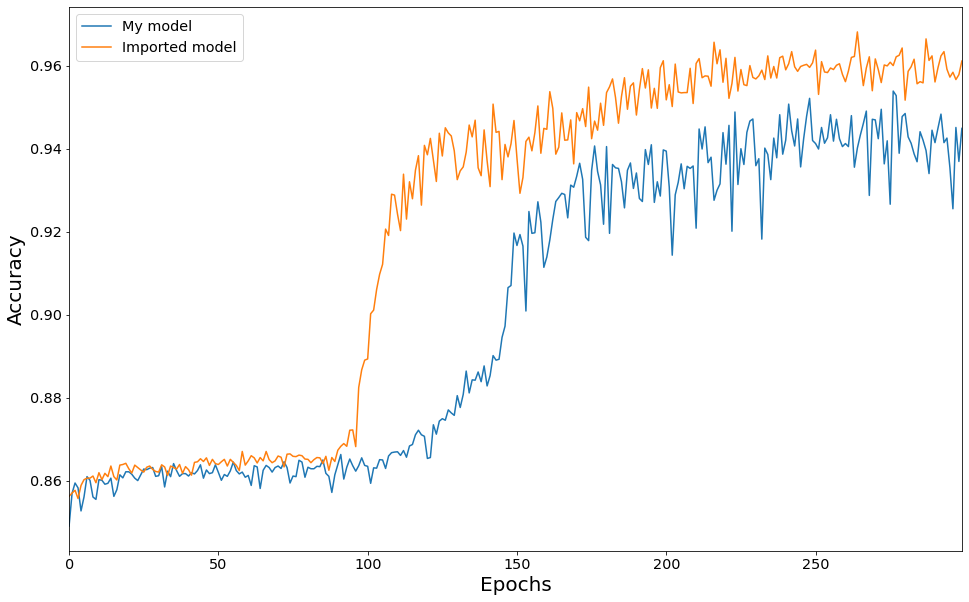

In [162]:
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': '150',
         'axes.titlesize':'40',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.figure(figsize=(16,10))
plt.xlabel('Epochs',fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
val = plt.plot(history_1.epoch, history_1.history['val_'+'accuracy'],
             label='My model')
plt.plot(history.epoch, history.history['val_'+'accuracy'],
             label='Imported model')
plt.legend()
plt.xlim([0,max(history.epoch)])
plt.show()

# Check agreement test

In [97]:
model1.predict(train_df)

array([[0.5613122 ],
       [0.23757538],
       [0.8062434 ],
       ...,
       [0.9458763 ],
       [0.98580605],
       [0.80701643]], dtype=float32)

In [160]:
check_agreement = pandas.read_csv(folder + 'check_agreement.csv.zip', index_col='id')
check_agreement = add_features(check_agreement)
check_agreement1 = check_agreement[variables_mod].to_numpy()
check_agreement1 = preprocess_data(check_agreement1)
agreement_probs = model1.predict(check_agreement1).squeeze()
print(agreement_probs)
ks = evaluation.compute_ks(
    agreement_probs[check_agreement['signal'].values == 0],
    agreement_probs[check_agreement['signal'].values == 1],
    check_agreement[check_agreement['signal'] == 0]['weight'].values,
    check_agreement[check_agreement['signal'] == 1]['weight'].values)
print('KS metric', ks, ks < 0.09)

[0.9480037  0.290546   0.98765534 ... 0.9776523  0.99747735 0.9989417 ]
KS metric 0.15859979424309834 False


# Check correlation test

In [161]:
check_correlation = pandas.read_csv(folder + 'check_correlation.csv.zip', index_col='id')
check_correlation = add_features(check_correlation)
check_correlation1 = check_correlation[variables_mod].to_numpy()
check_correlation1 = preprocess_data(check_correlation1)
correlation_probs = model1.predict(check_correlation1).squeeze()
#pd.DataFrame(correlation_probs,
                   #columns=[variables])
print(correlation_probs)
cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
print('CvM metric', cvm, cvm < 0.002)

[0.54133826 0.14893672 0.27048025 ... 0.99715084 0.98341584 0.63590246]
CvM metric 0.04178496983374544 False


# Compute weighted AUC on the training data with min_ANNmuon > 0.4

In [159]:
train_eval = data[data['min_ANNmuon'] > 0.4]
train_probs = model.predict(train_eval[variables_mod].to_numpy()).squeeze()
AUC = sklearn.metrics.roc_auc_score(train_eval['signal'], train_probs)
print('AUC', AUC)

AUC 0.5


# Predict test, create file for kaggle

In [42]:
result = pandas.DataFrame({'id': test.index})
result['prediction'] = model.predict(test[variables].to_numpy()).squeeze()

In [43]:
result.to_csv('submission.csv', index=False, sep=',')

In [ ]:
!ls -l submission.csv

In [ ]:
result.to_csv?